## Описание проекта

В нашем распоряжении датасет с историческими данными и факторами заемщиков.

Целью проекта является построение скоринговой модели, которая позволит максимизировать совокупную экономическую прибыль (в процентах от суммы выдачи). Скоринговая модель получает на вход значения факторов, на выходе выдает ответ, нужно ли выдавать данный заим.

**План работы следующий:**

1. Загрузить и провести первичный анализ данных, получить общую информацю;
2. Провести разведовательный анализ данных, проверить дубликаты, выбросы, типы данных. Исправить проблемы в данных;
3. На основании бизнес задачи интегрировать дополнительные данные;
4. Выбрать метрику или метрики для оценки качества разрабатываемой модели;
4. Сформировать рабочие признаки и таргет, дополнительно проверить их;
5. Выбрать несколько моделей, оптимизировать их гипперпараметры, сравнить метрики качества и выбрать лучшую модель;
6. На основе предсказаний модели провести анализ экономической прибыли;
7. Провести анализ важности признаков.




# 1. Загрузка данных и библиотек, первичный анализ

Устанавливаем и импортируем нужные библиотеки.

In [ ]:
!pip install -q unidecode
!pip install -q imbalanced-learn
!pip install -q catboost
!pip install -q optuna
!pip install -q lightgbm
!pip install -q shap
!pip install -q phik

In [ ]:
import unidecode

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
import shap

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from catboost import Pool
from lightgbm import LGBMClassifier

import optuna



In [ ]:
pd.options.display.float_format = '{:,.4f}'.format

Загружаем данные.

In [ ]:
try:
    path = '/content/drive/MyDrive/DS/data.xlsx'
    df = pd.read_excel(path)
except:
    df = pd.read_excel('data.xlsx')
else:
    path = '/content/drive/MyDrive/DS/data.csv'
    df = pd.read_csv(path)

Посмотрим на данные.

In [ ]:
df.head(5)

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,3 170 000 ₽,7,0.0530,211 051 ₽,862 850 ₽,0.0150,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500 000 ₽,17,0.0650,39 518 ₽,289 518 ₽,0.1000,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,11 600 897 ₽,9,0.0450,537 680 ₽,9 567 386 ₽,0.0150,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,5 250 000 ₽,13,0.0450,233 022 ₽,2 858 022 ₽,0.0150,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,3 000 000 ₽,8,0.0375,216 485 ₽,0 ₽,0.0000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(532, 28)

В данных 28 столбцов и 532 записи.

# 2. Разведовательный анализ данных

Выводим общую информацию.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 28 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Loan issued                                                                       532 non-null    object 
 1   Рейтинг                                                                           532 non-null    int64  
 2   Comission, %                                                                      532 non-null    float64
 3   Earned interest                                                                   532 non-null    object 
 4   Unpaid,  full amount                                                              532 non-null    object 
 5   EL                                                                                532 non-null    float64
 6   уч

**Что нужно сделать:**
- Необходимо переименовать столбцы.
- Столбцы `Loan issued`, `Earned interest`, `Unpaid,  full amount` имеют тип object. Нужно поменять их тип.

Переименуем столбцы.

In [ ]:
df = df.rename(columns={'Loan issued': 'loan_issued',
                   'Рейтинг': 'rating',
                   'Comission, %': 'commission',
                   'Earned interest': 'earned_interest',
                   'Unpaid,  full amount': 'unpaid',
                   'EL':'el',
                   'учредителю подсказывают / на ВИ другой человек': 'is_suggested',
                   'На ВИ присутствует "сотрудник", в тч за кадром, который отвечает на вопросы': 'employee_is_presented',
                   '"Сотрудник" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.': 'ceo_is_silent',
                   'В компании была смена учредителя': 'founder_is_changed',
                   'учредитель женщина' : 'is_woman',
                   'Первое ЮЛ': 'is_first_entity',
                   'Выручка компании в первый год > 30 млн.': 'is_revenue_more_30',
                   'Текущее ЮЛ основано до 30 лет': 'age_under_30',
                   'КИ учредителя < 1 млн': 'ki_above_1',
                   'Не знает объем выручки': 'doesnt_know_revenue',
                   'Не знает ФОТ': 'doesnt_know_payroll',
                   'Не знает контрагентов': 'doesnt_know_partners',
                   'Не знает наценку (рентабельность, прибыль)': 'doesnt_know_margin',
                   'Не знает кредиторов ), в тч объем обязательств': 'doesnt_know_creditors',
                   'Нерелевантный опыт работы': 'irrelevant_exp',
                   'Нелогичный выбор сферы бизнеса': 'illogical_business_choice',
                   'За ответом на вопросы 10-14 просит обратиться к сотруднику' : 'need_help',
                   'Данные предоставленные заемщиком разнятся с действительностью > 50%' : 'data_is_wrong',
                   'Есть "партнер", который официально не оформлен' : 'illegal_partner',
                   'Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками': 'agreements_with_suppliers',
                   'Офис находится в здании партнера/друга/родственника, аренду не платит.': 'doesnt_pay_rent',
                   'Заемщик от партнера и был подготовлен к ВИ': 'borrower_was_prepared'
    }
)

Уберем знак рубля и преобразуем данные в целочисленный тип данных

In [ ]:
def replace_rubles(df=df, columns=[]):
    for column in columns:
        df[column] = df[column].apply(lambda x: unidecode.unidecode(x[:-2]).replace(' ', '')).astype('int')

In [ ]:
replace_rubles(columns=['loan_issued', 'earned_interest', 'unpaid'])

Смотрим пропуски.

In [ ]:
df.isna().sum()

loan_issued                  0
rating                       0
commission                   0
earned_interest              0
unpaid                       0
el                           0
is_suggested                 0
employee_is_presented        0
ceo_is_silent                0
founder_is_changed           0
is_woman                     0
is_first_entity              0
is_revenue_more_30           0
age_under_30                 0
ki_above_1                   0
doesnt_know_revenue          0
doesnt_know_payroll          0
doesnt_know_partners         0
doesnt_know_margin           0
doesnt_know_creditors        0
irrelevant_exp               0
illogical_business_choice    0
need_help                    0
data_is_wrong                0
illegal_partner              0
agreements_with_suppliers    0
doesnt_pay_rent              0
borrower_was_prepared        0
dtype: int64

Пропусков нет.

Проверяем дубликаты.

In [ ]:
df.duplicated().sum()

0

Явных дубликатов нет.

Посмотрим на значения в столбцах с признаками.

In [ ]:
for column in df.drop(columns=['loan_issued', 'rating', 'commission', 'earned_interest', 'unpaid', 'el']).columns:
    print(f'Уникальные значения в столбце {column} {df[column].unique()}')

Уникальные значения в столбце is_suggested [0 1]
Уникальные значения в столбце employee_is_presented [0 1]
Уникальные значения в столбце ceo_is_silent [0 1]
Уникальные значения в столбце founder_is_changed [0 1]
Уникальные значения в столбце is_woman [0 1]
Уникальные значения в столбце is_first_entity [1 0]
Уникальные значения в столбце is_revenue_more_30 [0 1]
Уникальные значения в столбце age_under_30 [0 1]
Уникальные значения в столбце ki_above_1 [1 0]
Уникальные значения в столбце doesnt_know_revenue [0 1]
Уникальные значения в столбце doesnt_know_payroll [0 1]
Уникальные значения в столбце doesnt_know_partners [0 1]
Уникальные значения в столбце doesnt_know_margin [0 1]
Уникальные значения в столбце doesnt_know_creditors [0 1]
Уникальные значения в столбце irrelevant_exp [0 1]
Уникальные значения в столбце illogical_business_choice [0 1]
Уникальные значения в столбце need_help [0 1]
Уникальные значения в столбце data_is_wrong [0 1]
Уникальные значения в столбце illegal_partner [0 

Проверим есть ли в данных записи, где отсутсвует "сотрудник", но стоит 1 в поле, что ему подсказывают или директор молчит

In [ ]:
len(df[(df['employee_is_presented'] == 0 ) & (df['ceo_is_silent'] == 1)])

16

In [ ]:
len(df[(df['employee_is_presented'] == 0) & (df['is_suggested'] == 1)])

9

Удалим такие записи

In [ ]:
df = df[~((df['employee_is_presented'] == 0 ) & (df['ceo_is_silent'] == 1))]
df = df[~((df['employee_is_presented'] == 0) & (df['is_suggested'] == 1))]

Теперь аномальных значений нет.

Дополнительно посмотрим на корреляцию используя библиотеку Phik.

interval columns not set, guessing: ['loan_issued', 'rating', 'commission', 'earned_interest', 'unpaid', 'el', 'is_suggested', 'employee_is_presented', 'ceo_is_silent', 'founder_is_changed', 'is_woman', 'is_first_entity', 'is_revenue_more_30', 'age_under_30', 'ki_above_1', 'doesnt_know_revenue', 'doesnt_know_payroll', 'doesnt_know_partners', 'doesnt_know_margin', 'doesnt_know_creditors', 'irrelevant_exp', 'illogical_business_choice', 'need_help', 'data_is_wrong', 'illegal_partner', 'agreements_with_suppliers', 'doesnt_pay_rent', 'borrower_was_prepared']


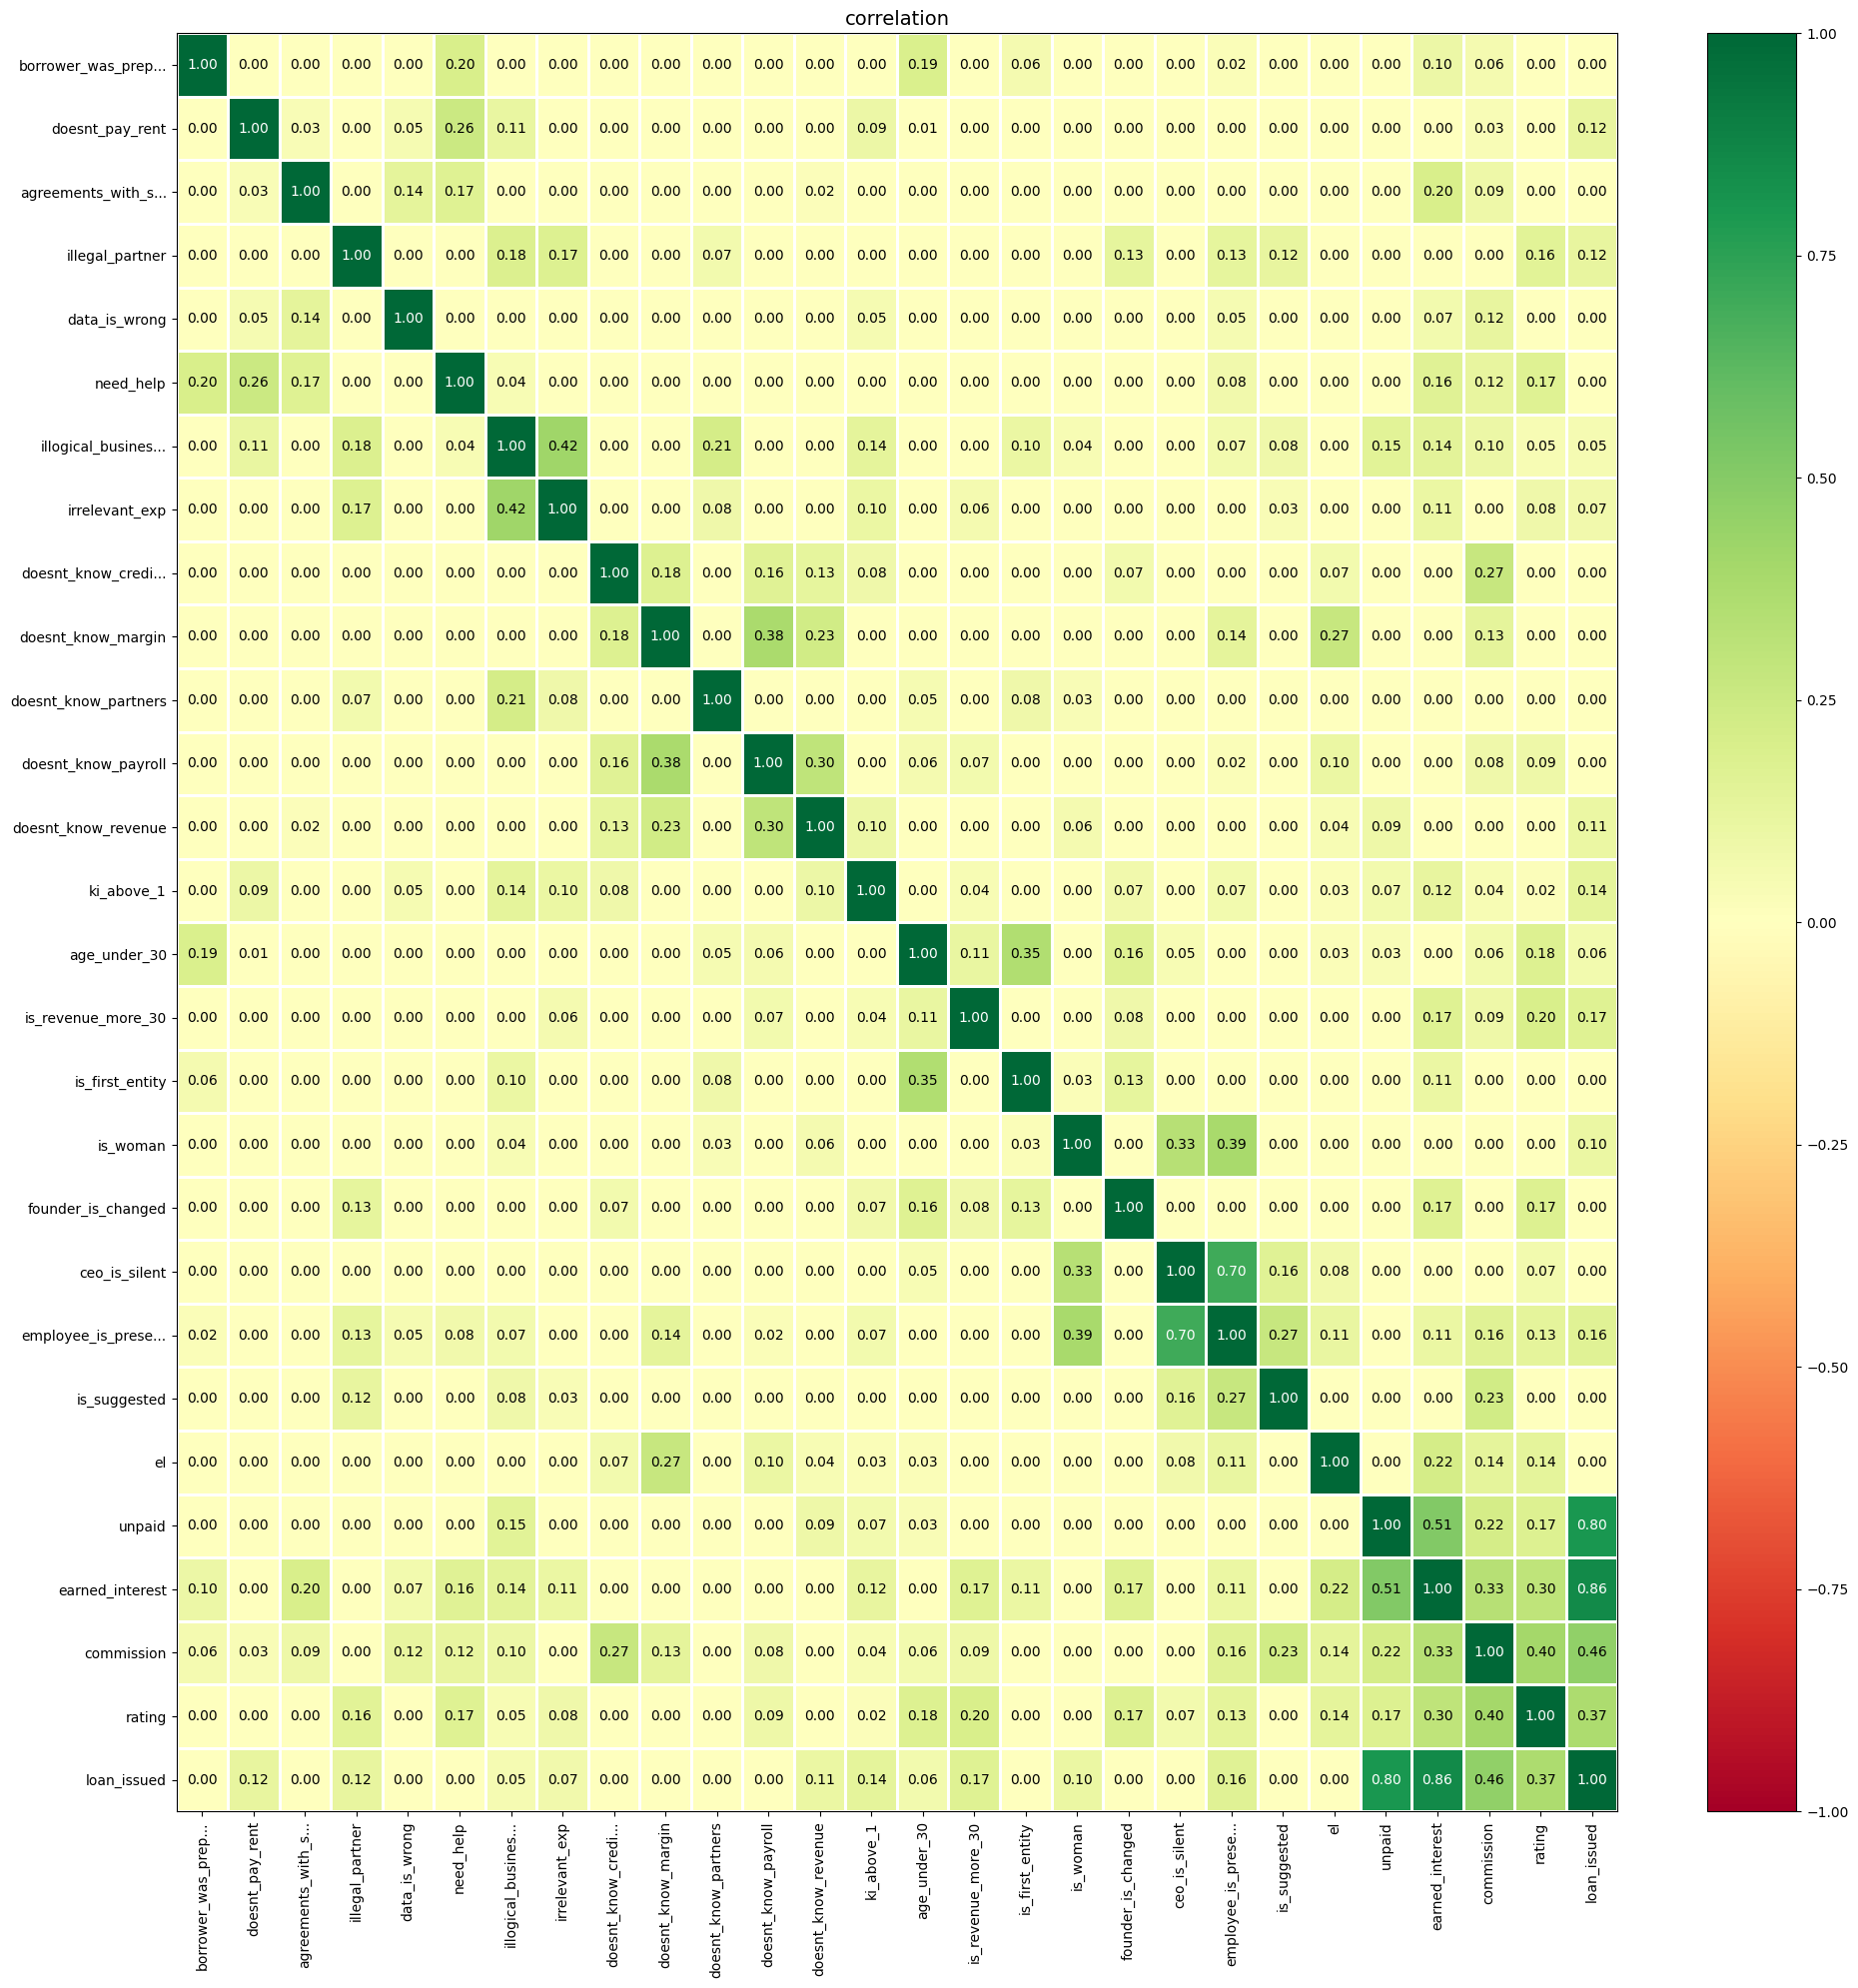

In [ ]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,  figsize=(20, 20))

Есть корреляция между столбцами `loan_issued`, `unpaid` и `earned_interest`. Эти данные не войдут в фичи и таргет поэтому оатсвляем все как есть.

**Итого:**

Дубликатов, пропусков и аномальных значений в данных нет. Типы данных приведены к нужным.

# 3. Анализ прибыли на имеющихся данных

Значение экономической прибыли считается следующим образом:
- loss = unpaid * el
- investor_profit = earned — loss
- profit = investor_profit + commission
- perc_profit = profit / loan_issued

Создадим дополнительные столбцы

In [ ]:
df['loss'] = df['unpaid'] * df['el']
df['investor_profit'] = df['earned_interest'] - df['loss']
df['profit'] = df['investor_profit'] + df['commission']
df['perc_profit'] = df['profit'] / df['loan_issued']
df[['loan_issued', 'earned_interest' ,'loss', 'investor_profit', 'profit', 'perc_profit']].sample(10)

,loan_issued,earned_interest,loss,investor_profit,profit,perc_profit
185,2348835,357513,0.0000,"357,513.0000","357,513.0650",0.1522
499,3500000,175280,"28,879.2000","146,400.8000","146,400.8300",0.0418
365,3470000,44014,"54,974.7600","-10,960.7600","-10,960.6950",-0.0032
133,11200000,393476,"145,818.3450","247,657.6550","247,657.6815",0.0221
449,4000000,164177,"299,502.0000","-135,325.0000","-135,324.9450",-0.0338
263,2545267,248938,"7,109.9850","241,828.0150","241,828.0750",0.0950
478,2800000,104173,"31,125.1950","73,047.8050","73,047.8600",0.0261
88,12400000,539558,"821,379.7000","-281,821.7000","-281,821.6458",-0.0227
85,11250000,357828,"138,155.7150","219,672.2850","219,672.3242",0.0195
230,4000000,100329,"31,504.9350","68,824.0650","68,824.1050",0.0172


In [ ]:
(df['profit'].sum() / df['loan_issued'].sum()) * 100

0.8377168710110424

Сечас процент прибыли составляет 0,8%

Создадим столбец-индикатор, что прибыль положительная - 1 обозначим наличие прибыли, 0 обозначим наличие убытков. Это и будет целевым признаком.

In [ ]:
df['is_profit'] = (df['profit'] > 0).astype(int)
df['is_profit']

0      1
1      1
2      1
3      1
4      1
      ..
527    1
528    1
529    0
530    1
531    1
Name: is_profit, Length: 508, dtype: int64

Посмотрим на распределение классов.

In [ ]:
df['is_profit'].value_counts()

1    389
0    119
Name: is_profit, dtype: int64

In [ ]:
df['is_profit'].value_counts(normalize=True)

1   0.7657
0   0.2343
Name: is_profit, dtype: float64

Около 76% займов принесли прибыль.

Итоговый датафрейм.

In [ ]:
df.sample(5)

,loan_issued,rating,commission,earned_interest,unpaid,el,is_suggested,employee_is_presented,ceo_is_silent,founder_is_changed,...,data_is_wrong,illegal_partner,agreements_with_suppliers,doesnt_pay_rent,borrower_was_prepared,loss,investor_profit,profit,perc_profit,is_profit
240,3000000,9,0.0390,63831,3391299,0.0150,0,0,0,0,...,0,0,0,0,0,"50,869.4850","12,961.5150","12,961.5540",0.0043,1
336,10000000,11,0.0295,202163,4475705,0.0150,0,0,0,0,...,0,0,0,0,0,"67,135.5750","135,027.4250","135,027.4545",0.0135,1
385,3180000,16,0.0650,204976,1794976,0.0150,0,0,0,0,...,0,0,0,0,0,"26,924.6400","178,051.3600","178,051.4250",0.0560,1
304,500000,11,0.0600,24394,382121,0.0150,0,0,0,0,...,1,0,0,0,0,"5,731.8150","18,662.1850","18,662.2450",0.0373,1
468,4000000,14,0.0450,62542,4354623,0.0150,0,0,0,0,...,0,0,0,0,0,"65,319.3450","-2,777.3450","-2,777.3000",-0.0007,0


# 4. Выбор и обоснование метрики для оценки качества разрабатываемой модели.

Так как главная цель модели максимизировать совокупную экономическую прибыль, то необходимо максимизировать количество потенциально прибыльних займов и минимизировать количество потенциально убыточных. То есть решить задачу классификации.

Так как целевой признак несбалансирован, то мы не можем использовать метрику `Accuracy`. Будем исползовать метрики, на которые не влияет дисбаласнс.

Если нам необходимо найти долю правильно предсказанных положительных объектов среди всех объектов, предсказанных положительным классом, то мы бы использовали метрику `Precision`.

Если же мы ищем долю правильно найденных положительных объектов среди всех объектов положительного класса, то мы используем `Recall`.

В нашем случаем `Precision` показывает, сколько из определённых нами как благоприятных заемщиков действительно являются благоприятными, а `Recall` – какую долю благоприятных заемщиков нам удалось выявить их всего множества.

Тут все зависит от политики управления рисками компании - компания хочет выдавать как можно больше займов и с учетом их благонадежности, или искать только прибыльные займы жервтуя их количеством.

Если мы хотим учитывать и `Precision` и `Recall`, то берем их среднее гармоническое значение - `F1-score`. Ее и выберем как основной метрикой качества. Дополнительно будем смотерть и площадь под ROC кривой - ROC-AUC.


# 5. Формируем рабочие признаки и таргет

In [ ]:
features = df.drop(columns=[
    'loan_issued',
    'rating',
    'commission',
    'earned_interest',
    'unpaid',
    'el',
    'loss',
    'investor_profit',
    'profit',
    'perc_profit',
    'is_profit'
  ]
)
target = df['is_profit']

Заключительная проверка.

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 531
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   is_suggested               508 non-null    int64
 1   employee_is_presented      508 non-null    int64
 2   ceo_is_silent              508 non-null    int64
 3   founder_is_changed         508 non-null    int64
 4   is_woman                   508 non-null    int64
 5   is_first_entity            508 non-null    int64
 6   is_revenue_more_30         508 non-null    int64
 7   age_under_30               508 non-null    int64
 8   ki_above_1                 508 non-null    int64
 9   doesnt_know_revenue        508 non-null    int64
 10  doesnt_know_payroll        508 non-null    int64
 11  doesnt_know_partners       508 non-null    int64
 12  doesnt_know_margin         508 non-null    int64
 13  doesnt_know_creditors      508 non-null    int64
 14  irrelevant_exp            

In [ ]:
target.info()

<class 'pandas.core.series.Series'>
Int64Index: 508 entries, 0 to 531
Series name: is_profit
Non-Null Count  Dtype
--------------  -----
508 non-null    int64
dtypes: int64(1)
memory usage: 7.9 KB


Так как данных немнго, то дальнейшем будем использовать кросс-валидацию, поэтому разобъем данные только на обучающую и тестовую выборки. На тестовой выборке проверим качество итоговой модели и проведем экономический анализ.

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=0, shuffle=True, stratify = target)
print(f'В обучающей выборке {(features_train.shape[0] / len(df)):.1%} данных')
print(f'В тестовой выборке {(features_test.shape[0] / len(df)):.1%} данных')

В обучающей выборке 75.0% данных
В тестовой выборке 25.0% данных


Метрики выбрали, признаки сформировали, данные разбили можно приступать к построению модели.

# 6. Построение модели

В качестве моделей выберем на логистическую регрессию, случайный лес и градиентный бустинг на случайном лесе - CatBoost и LightGBM. Посмотрим на качество моделей из коробки, выберем лучшую и попробуем оптимизировать  гиперпараметры используя фреймворк Optuna.

Создадим датафрейм куда будем складывать значения метрик для сравнения.

In [ ]:
metrics = pd.DataFrame(index = ['forest', 'regression', 'catboost', 'lightgbm'],
                       data={'F1-score_mean': [0 for _ in range(4)],
                             'F1-score_std': [0 for _ in range(4)],
                             'ROC_AUC_mean': [0 for _ in range(4)],
                             'ROC_AUC_std': [0 for _ in range(4)]
  }
)
metrics

,F1-score_mean,F1-score_std,ROC_AUC_mean,ROC_AUC_std
forest,0,0,0,0
regression,0,0,0,0
catboost,0,0,0,0
lightgbm,0,0,0,0


Определим функцию для кросс-валидации.

In [ ]:
def get_cross_val_score(model, scoring='f1', cv=10):
    '''
    Функция для нахождения кросс-валидации. Принимает на вход модель, метрику(scoring) и количество фолдов(cv)
    На выход выдает кортеж с среднеим значением и стандартным отклонением метрики по всем фолдам.
    '''
    scores = cross_val_score(model, features_train, target_train, cv=cv, scoring=scoring)
    return round(scores.mean(), 3), round(scores.std(), 3)

Определим функцию для заполнения таблицы с метриками.

In [ ]:
def fill_metrics(model_in_metrics, model):
    '''
    Функция для заполнения таблицы с метриками. Принимает на вход название модели из таблицы  metrics и модель, для которой считаем метрики
    '''
    metrics.loc[model_in_metrics, 'F1-score_mean'], metrics.loc[model_in_metrics, 'F1-score_std'] =  get_cross_val_score(model, scoring='f1')
    metrics.loc[model_in_metrics, 'ROC_AUC_mean'], metrics.loc[model_in_metrics, 'ROC_AUC_std'] =  get_cross_val_score(model, scoring='roc_auc')

## Случайный лес

Объявляем модель.

In [ ]:
forest = RandomForestClassifier(random_state=0)

Заполняем таблицу.

In [ ]:
fill_metrics('forest', forest)

## Логистическая регрессия

Аналогично.

In [ ]:
reg = LogisticRegression(random_state=0)

In [ ]:
fill_metrics('regression', reg)

## CatBoost

In [ ]:
cat = CatBoostClassifier(verbose=False, random_state=0)

In [ ]:
fill_metrics('catboost', cat)

## LightGBM

In [ ]:
lgm = LGBMClassifier(random_state=0, verbose=-1)

In [ ]:
fill_metrics('lightgbm', lgm)

Итоговая таблица.

In [ ]:
metrics

,F1-score_mean,F1-score_std,ROC_AUC_mean,ROC_AUC_std
forest,0.8100,0.0530,0.5960,0.1160
regression,0.8590,0.0280,0.6140,0.1230
catboost,0.8480,0.0230,0.6090,0.1520
lightgbm,0.8400,0.0340,0.6140,0.1120


На данном этапе логистическая регрессия и catboost показали лучшие результаты метрик и их стандартных отклонений.

## Решение оптимизационной задачи

Попробуем оптимизировать гиперпараметры моделей используя фреймворк Optuna.

### Решение оптимизационной задачи для логистической регрессии

In [ ]:
def objective(trial):

    params = {
        'max_iter' : trial.suggest_int('max_iter' , 50, 150),
        'class_weight' : trial.suggest_categorical('class_weight', ['balanced', None]),
        'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
    }

    model = LogisticRegression(**params, random_state=0)

    return cross_val_score(model, features_train, target_train, cv=10, scoring='f1').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)
best_reg = LogisticRegression(**study.best_params, random_state=0)
get_cross_val_score(best_reg)

[I 2023-09-11 12:59:01,187] A new study created in memory with name: no-name-5bb994c5-2475-450c-a2ad-5bc90379fd16


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-09-11 12:59:01,335] Trial 0 finished with value: 0.7442790374364223 and parameters: {'max_iter': 67, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7442790374364223.
[I 2023-09-11 12:59:01,413] Trial 1 finished with value: 0.7442790374364223 and parameters: {'max_iter': 143, 'class_weight': 'balanced', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7442790374364223.
[I 2023-09-11 12:59:01,479] Trial 2 finished with value: 0.7442790374364223 and parameters: {'max_iter': 122, 'class_weight': 'balanced', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7442790374364223.
[I 2023-09-11 12:59:01,597] Trial 3 finished with value: 0.8593889828832761 and parameters: {'max_iter': 69, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.8593889828832761.
[I 2023-09-11 12:59:01,673] Trial 4 finished with value: 0.8593889828832761 and parameters: {'max_iter': 78, 'class_weight': None, 'solver': 'liblinear'}. Best is trial 3 with 

(0.859, 0.028)

In [ ]:
fill_metrics('regression_optuna', best_reg)
metrics

,F1-score_mean,F1-score_std,ROC_AUC_mean,ROC_AUC_std
forest,0.8100,0.0530,0.5960,0.1160
regression,0.8590,0.0280,0.6140,0.1230
catboost,0.8480,0.0230,0.6090,0.1520
lightgbm,0.8400,0.0340,0.6140,0.1120
regression_optuna,0.8590,0.0280,0.6140,0.1230


### Решение оптимизационной задачи для CatBoost

In [ ]:
def objective(trial):

    params = {
      "iterations": trial.suggest_int("iterations", 1, 100),
      "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
      "depth": trial.suggest_int("depth", 1, 15),
      # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
      # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostClassifier(**params, verbose=100, random_state=0)

    return cross_val_score(model, features_train, target_train, cv=5, scoring='f1').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
best_cat = CatBoostClassifier(**study.best_params, verbose=False, random_state=0)
get_cross_val_score(best_cat)

[I 2023-09-11 12:59:14,548] A new study created in memory with name: no-name-512d86a0-01e6-4500-9817-c5e57fa155b1


  0%|          | 0/50 [00:00<?, ?it/s]

0:	learn: 0.6128908	total: 2.55ms	remaining: 35.8ms
14:	learn: 0.3317197	total: 250ms	remaining: 0us
0:	learn: 0.6240626	total: 2.13ms	remaining: 29.8ms
14:	learn: 0.3877035	total: 246ms	remaining: 0us
0:	learn: 0.6108585	total: 2.21ms	remaining: 30.9ms
14:	learn: 0.3532975	total: 315ms	remaining: 0us
0:	learn: 0.6255070	total: 2.19ms	remaining: 30.7ms
14:	learn: 0.3804960	total: 160ms	remaining: 0us
0:	learn: 0.6040981	total: 11.4ms	remaining: 159ms
14:	learn: 0.3507382	total: 277ms	remaining: 0us
[I 2023-09-11 12:59:16,007] Trial 0 finished with value: 0.849879591062774 and parameters: {'iterations': 15, 'learning_rate': 0.19221766745379143, 'depth': 12}. Best is trial 0 with value: 0.849879591062774.
0:	learn: 0.6133138	total: 899us	remaining: 63ms
70:	learn: 0.3056623	total: 55.8ms	remaining: 0us
0:	learn: 0.6180028	total: 943us	remaining: 66ms
70:	learn: 0.3243758	total: 47.3ms	remaining: 0us
0:	learn: 0.6098674	total: 916us	remaining: 64.1ms
70:	learn: 0.3178330	total: 49.3ms	rem

(0.864, 0.011)

In [ ]:
study.best_params

{'iterations': 23, 'learning_rate': 0.01141303145793671, 'depth': 7}

In [ ]:
fill_metrics('catboost_optuna', best_cat)

In [ ]:
metrics

,F1-score_mean,F1-score_std,ROC_AUC_mean,ROC_AUC_std
forest,0.8100,0.0530,0.5960,0.1160
regression,0.8590,0.0280,0.6140,0.1230
catboost,0.8480,0.0230,0.6090,0.1520
lightgbm,0.8400,0.0340,0.6140,0.1120
regression_optuna,0.8590,0.0280,0.6140,0.1230
catboost_optuna,0.8640,0.0110,0.6000,0.1470


После оптимизации гиперпараметров модель CatBoost имеет лучшие метрики и их стандартные отклонения на кросс-валидации. Ее и будем использовать в дальнейшем.

## Борьба с дисбалансом

Попробуем поработать с дисбалансом. Для этого используем оверспемлинг техникой SMOTE и RandomOverSampler.

### Логистическая регрессия

Соберем пайплайн - первым шагом будет увеличивать выборку, вторым шагом будем прогонять через модель.

In [ ]:
steps = [('sampler', RandomOverSampler()), ('model', best_reg)]
pipeline = Pipeline(steps=steps)
fill_metrics('reg_RandomOverSampler', pipeline)
pipeline

Pipeline(steps=[('sampler', RandomOverSampler()),
                ('model', LogisticRegression(max_iter=69, random_state=0))])

In [ ]:
steps = [('sampler', SMOTE(random_state=0)), ('model', best_reg)]
pipeline = Pipeline(steps=steps)
fill_metrics('reg_SMOTE', pipeline)
pipeline

Pipeline(steps=[('sampler', SMOTE(random_state=0)),
                ('model', LogisticRegression(max_iter=69, random_state=0))])

### CatBoost

In [ ]:
steps = [('sampler', RandomOverSampler()), ('model', best_cat)]
pipeline = Pipeline(steps=steps)
fill_metrics('cat_RandomOverSampler', pipeline)
pipeline

Pipeline(steps=[('sampler', RandomOverSampler()),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x79401afb3a30>)])

In [ ]:
steps = [('sampler', SMOTE(random_state=0)), ('model', best_cat)]
pipeline = Pipeline(steps=steps)
fill_metrics('cat_SMOTE', pipeline)
pipeline

In [ ]:
metrics

,F1-score_mean,F1-score_std,ROC_AUC_mean,ROC_AUC_std
forest,0.8100,0.0530,0.5960,0.1160
regression,0.8590,0.0280,0.6140,0.1230
catboost,0.8480,0.0230,0.6090,0.1520
lightgbm,0.8400,0.0340,0.6140,0.1120
regression_optuna,0.8590,0.0280,0.6140,0.1230
catboost_optuna,0.8640,0.0110,0.6000,0.1470
reg_RandomOverSampler,0.7320,0.0810,0.5990,0.1060
reg_SMOTE,0.6790,0.0960,0.5870,0.1630
cat_RandomOverSampler,0.7840,0.0710,0.6100,0.1410
cat_SMOTE,0.6800,0.0850,0.5310,0.1540


После выравнивания классов не удалось достичь улучшения метрик.

# 6.1 Альтернативный подход к решению задачи

В нашей задачи нам важно не только верно идентифицировать благонадежные займы, то есть их классификация, но и некоторое ранжирование - какие клиенты более склонны к возврату займа, а какие нет. Для этого можно посмотреть на порог принятия решения (в задаче класификации он равен 0,5 по умолчанию) и подобрать порог вручную в зависимости от экономических соображений.

Для такого анализа будем использовать не само предсказания модели (1 или 0), а предсказания вероятности принадлежности к классу.

In [ ]:
reg.fit(features_train, target_train)
probabolities = reg.predict_proba(features_test)[:, 1]

Создадим датасет с вероятностью принадлежности к классу (`probabolities`) и действительным значением (`valid_target`) он же `is_profit`.

In [ ]:
prob_data = pd.DataFrame(index = target_test.index,
                  data={'probabolities': probabolities,
                        'valid_target': target_test
    }
)
prob_data.sample(5)

,probabolities,valid_target
503,0.9071,1
325,0.4894,0
316,0.7632,1
225,0.8076,1
69,0.3667,0


Как в задаче класссификации зададим порог 0.5 и вычислим предсказания (`predictions_with_treshold`) относительно этого порога.

In [ ]:
treshold = 0.5
prob_data['predictions_with_treshold'] = prob_data['probabolities'].apply(lambda x: x > treshold).astype(int)
prob_data.sample(5)

,probabolities,valid_target,predictions_with_treshold
115,0.8288,1,1
178,0.6981,1,1
21,0.6334,1,1
359,0.8836,1,1
528,0.8060,1,1


Далее эти данные используем для анализа экономической прибыли.

# 7. Анализ экономической прибыли

Соберем тестовый датасет для анализа признаков, он содержит записи с индексами целевого признака из тестового множества.

In [ ]:
df_test = df.loc[target_test.index,['loan_issued', 'rating', 'commission', 'earned_interest', 'unpaid', 'el', 'loss', 'profit', 'is_profit']]
df_test['predictions_with_treshold'] = prob_data['predictions_with_treshold']
df_test.sample(5)

,loan_issued,rating,commission,earned_interest,unpaid,el,loss,profit,is_profit,predictions_with_treshold
174,2500000,15,0.0413,101036,1598893,0.0000,0.0000,"101,036.0413",1,1
190,3000000,10,0.0320,250400,550080,0.1000,"55,008.0000","195,392.0320",1,1
105,2070000,14,0.0423,0,2359393,0.0150,"35,390.8950","-35,390.8527",0,1
367,500000,13,0.0650,12197,477651,1.0000,"477,651.0000","-465,453.9350",0,1
228,1000000,16,0.0350,0,1080210,0.0150,"16,203.1500","-16,203.1150",0,1


Так как модель предсказывает возврат займа неидеально, то для корректного расчета прибыли после внедрения модели, нужно одновременно учитывать факт наличия прибыли и предсказания модели. Можно рассмотреть все возможные варианты:
- `is_profit` = 0, `prediction` = 0 — модель предсказала, что зайим не вернется, и его не вернули. В таком случае мы бы не выдали займ и не потеряли бы деньги;
- `is_profit` = 0, `prediction` = 1 — модель предсказала, что займ вернут, но его не вернули. В этом случае мы теряем деньги по причине невозврата займа;
- `is_profit` = 1, `prediction` = 0 — модель предсказала невозврат займа, но его вернули. В таком случае мы упускаем прибыль по причине упущенной комиссии, но и не теряем деньги;
- `is_profit` = 1, `prediction` = 1 — модель предсказала возврат займа, и его вернули. В таком случае мы зарабатываем.

Определим функцию для нахождения прибыли.

In [ ]:
def predict_profit(df):
    '''
    Функция для нахождения прибыли
    '''
    profit = 0
    if df['is_profit'] == 1 and df['predictions_with_treshold'] == 1:
        profit += df['profit']
    if df['is_profit'] == 1 and df['predictions_with_treshold'] == 0:
        pass
    if df['is_profit'] == 0 and df['predictions_with_treshold'] == 1:
        profit += df['profit'] # суммируем потому-что в таком случае прибыль отрицательная
    if df['is_profit'] == 0 and df['predictions_with_treshold'] == 0:
        pass
    return profit

In [ ]:
df_test['predicted_profit'] = df_test.apply(predict_profit, axis=1)

Находим итоговую прибыль.

In [ ]:
print(f'После внедрения модели с порогом {treshold} прибыль составит {df_test["predicted_profit"].sum():.0f} рублей')
print(f'Что составит {(df_test["predicted_profit"].sum() / df_test[df_test["predictions_with_treshold"] == 1]["loan_issued"].sum()):.2%} от суммы займов')

После внедрения модели с порогом 0.5 прибыль составит 5746053 рублей
Что составит 1.62% от суммы займов


In [ ]:
print(f'Прирост прибыли полле введения модели составит {(df_test["predicted_profit"].sum() - df_test["profit"].sum()):.1f} рублей')

Прирост прибыли полле введения модели составит 118854.9 рублей


Теперь проведем анализ прибыли в зависимости от порога принятия решения.

Соберем все вместе - определим функция для нахождения прибыли в зависимости от порога.

In [ ]:
def find_profit_with_treshold(probabolities=probabolities,
                              treshold=0.5,
                              target=target_test,
                              profit=df.loc[target_test.index,'profit'],
                              loan_issued=df.loc[target_test.index,'loan_issued'],
                              return_df=False):
    '''
    Функция для нахождения суммарной прибыли в зависимости от порога
    '''
    df = pd.DataFrame()
    df['predictions_with_treshold'] = pd.Series(probabolities).apply(lambda x: x > treshold).astype(int)
    df['is_profit'] = list(target_test)
    df['profit'] = list(profit)
    df['loan_issued'] = list(loan_issued)
    df['predicted_profit'] = df.apply(predict_profit, axis=1)
    if return_df:
        return df, round(df['predicted_profit'].sum(), 2)
    return round(df['predicted_profit'].sum(), 2)

Определим функция для нахождения опитимального порога и суммарной прибыли при этом пороге.

In [ ]:
def find_treshold(model, treshold_min=0, treshold_max=1, treshold_step=0.001):
    '''
    Функция для нахождения оптимального порога и маскимальной прибыли
    Принимает на вход модел и пространство поиска порога
    Возвращает кортеж с прибылью и порогом, при котором достигается максимальная прибыль
    '''
    probabolities = model.fit(features_train, target_train).predict_proba(features_test)[:, 1]
    dic = dict() # Будем складывать в словарь значение прибыли, ключами будет порог
    for treshold in np.arange(treshold_min, treshold_max, treshold_step):
        dic[treshold] = find_profit_with_treshold(probabolities, treshold) - df_test['profit'].sum()
    return round(dic[max(dic, key=dic.get)], 2), max(dic, key=dic.get)

In [ ]:
sum_profit, best_treshold = find_treshold(best_cat)

In [ ]:
df_with_loan = find_profit_with_treshold(return_df=True, treshold=best_treshold)[0]
perc = df_with_loan['predicted_profit'].sum() / df_with_loan[df_with_loan['predictions_with_treshold'] == 1]['loan_issued'].sum()

In [ ]:
print(f'В результате подбора порога принятия решения удалось достичь прироста прибыли в {sum_profit} рублей, что составило {perc:1%} от суммы выдачи кредитов, оптимальный порог в таком случае составляет {best_treshold}.')

В результате подбора порога принятия решения удалось достичь прироста прибыли в 720529.39 рублей, что составило 1.836725% от суммы выдачи кредитов, оптимальный порог в таком случае составляет 0.542.


Таким образом удалось достичь прироста прибыли (в процентах от суммы выдачи) в два раза.

# 8. Анализ признаков

Посмотрм на распределение важности признаков для того чтобы лучше понять каким образом принимается решения о выдаче займа и какие признаки наиболее важны.

In [ ]:
importances = pd.DataFrame({"features": best_cat.feature_names_, "scores": best_cat.feature_importances_}).sort_values(by='scores', ascending=False)
importances

,features,scores
15,illogical_business_choice,14.5017
16,need_help,9.6371
19,agreements_with_suppliers,8.6229
1,employee_is_presented,8.4675
14,irrelevant_exp,8.0210
10,doesnt_know_payroll,6.8213
9,doesnt_know_revenue,4.7366
2,ceo_is_silent,4.5778
13,doesnt_know_creditors,4.5601
4,is_woman,4.3821


Дополнительно посмотрим на важность признаков используя библиотеку SHAP.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


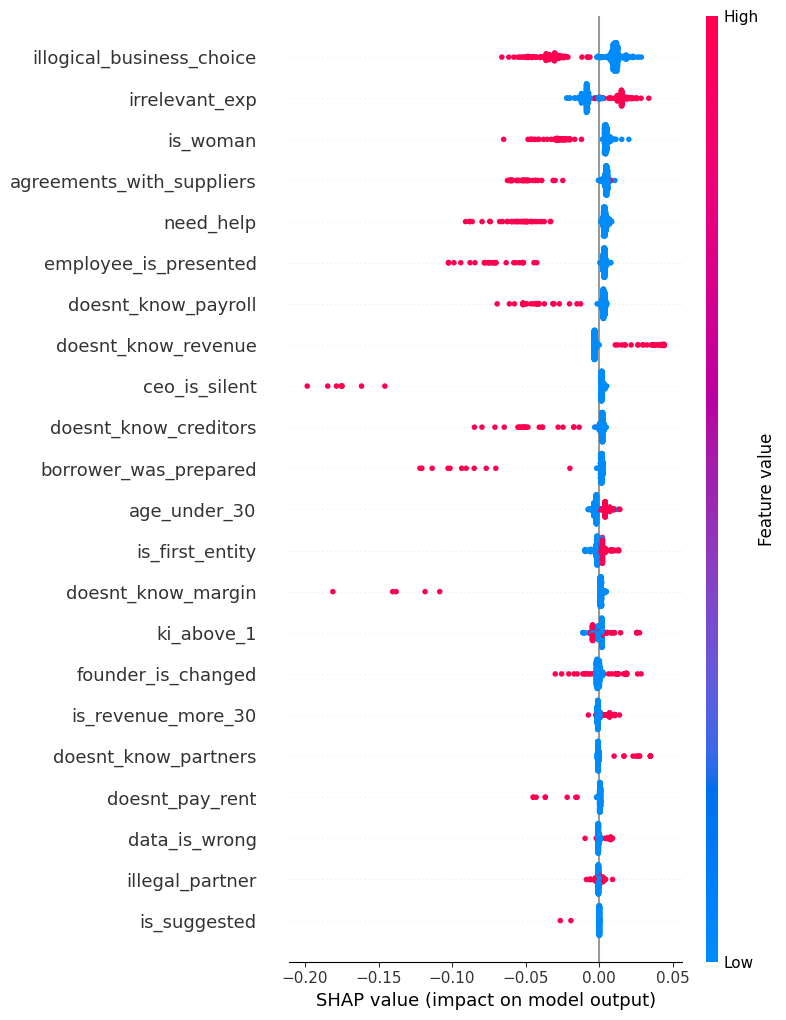

In [ ]:
shap_test = shap.TreeExplainer(best_cat).shap_values(features)
shap.summary_plot(shap_test, features, max_display=25)

Распределение признаков получились практически идентичным, можно отметить, что наиболее важными признаками являются релеватность опыта, выбор среды бизнеса, возраст и наличие сотрудника, который помогает с 10-14 вопросами, если он есть. Наименее важными признаками являются наличие сотрудника, который отвечает за владельца, наличие денег для начала бизнес, знание директора некоторых финансовых показателей.

# 9. Вывод

В результате выполненной работы была разработана скоринговая модель машшиного обучения для выявления благонадежных клиентов. На тестовых данных модель показала прирост прибыли 720529.39 рублей, и прирост в два раза в отношении прибыли к сумме выданных займов до введения модели.

Была иследована важность признаков и их влияние на принятие решения о выдаче или отказе в займе.

Для улучшения работы модели можно предлоджить введение новых, не обязательно бинарных, признаков, например возраста, уровня образования, наличия детей кредитные истории и тп, можно попробовать синтезировать новые признакми.

Дополнительно можно разработать мета-модель используя стекинг и моедли, которые изучались выше.